In [1]:
import numpy as np
from scipy.integrate import odeint, quad
import matplotlib.pyplot as plt
from math import tanh, sqrt

### Коэффициенты [1, c.4] ###

# Кинетика глюкозы
VG = 1.88 # объем распределения глюкозы, dl/kg
k1 = 0.065 # параметр скорости, 1/min
k2 = 0.079 # параметр скорости, 1/min
# Кинетика инсулина 
VI = 0.05 # объем распределения инсулина, l/kg
m1 = 0.190 # параметр скорости, 1/min
m2 = 0.484 # параметр скорости, 1/min
m4 = 0.194 # параметр скорости (периферийной деградации инсулина), 1/min
m5 = 0.0304 # параметр для расчета экстракции инсулина печенью, min * kg/pmol
m6 = 0.6471 # параметр для расчета экстракции инсулина печенью, (безразмерная)
HEb = 0.6 # базальный уровень экстракции инсулина печенью (отношение потока полностью покидающего печень инсулина к общему потоку инсулина) (безразмерная)
# EGP (эндогенное производство глюкозы)
kp1 = 2.70 # экстраполироанный EGP при нулевых глюкозе и инсулине, mg/kg/min
kp2 = 0.0021 # эффективность выделения глюкозы печенью, 1/min
kp3 = 0.009 # параметр амлитуды воздействия инсулина на печень, mg/kg/mni per pmol/l
kp4 = 0.0618 # параметр амлитуды воздействия инсулина в воротной вене (portal vein) на печень, mg/kg/mni per pmol/l
ki = 0.0079 # параметр задержки между сигналом инсулина и действием инсулина
# Скорость появления (глюкозы в крови)
kmax = 0.0558 # максимальная скорость всасывания (1/min)
kmin = 0.0080 # минимальная скорость всасывания (1/min)
kabs = 0.057 # скорость всаывания в кишечнике (1/min)
kgri = 0.0558 # скорость измельчения(1/min)
f = 0.90 # коэффициент-отношение глюкозы, попавшей в плазму к глюкозе, которая всасывалась в кишечнике (безразм.)
a = 0.00013 # 1/mg - не используется
b = 0.82 # безразм. - (в модели ЖКТ [2] это b) - процент дозы, для которой kempt увеличивается до (kmax - kmin)/2
c = 0.00236 # 1/mg - не используется
d = 0.010 # безразм. - (в модели ЖКТ [2] это c) - процент дозы, для которой kempt уменьшается до (kmax - kmin)/2
# Утилизация глюкозы
Fcns = 1 #1 # утилизация глюкозы мозгом и эритроцитами (mg/kg/min)
Vm0 = 2.50 # коэффициент для расчета Uid (mg/kg/min)
Vmx = 0.047 # коэффициент для расчета Uid (mg/kg/min per pmol/l)
Km0 = 225.59 # коэффициент для расчета Uid (mg/kg)
p2U = 0.0331 # параметр скорости действия инсулина по перифейрийной утилизации глюкозы (1/min)
Kmx = 0 # коэффициент равен 0, [1, c. 6]
# Секреция инсулина
K = 2.30 # коэффициент реакции поджелудочной на скорость изменения глюкозы, pmol/kg per mg/dl
alpha = 0.050 # параметр задержки между сигналом о глюкозы и выделение инсулина, 1/min
beta = 0.11 # параметр реагирования поджелудочной железы на глюкозу, pmol/kg/min per mg/dl
upsilon = 0.5 # параметр скорости передачи инсулина между воротной веной, (portal vein) и печенью, 1/min
# Почечная экскреция
ke1 = 0.0005 # скорость глобулярной фильтрации ,1/min
ke2 = 339 # почечный порого для глюкозы ,mg/kg

# Подкожный инсулин
kd = 0.0164  # скорость диссоциации инсулина, 1/min
ka1 = 0.0018  # скорость абсорбции немономерного инсулина, 1/мин
ka2 = 0.0182  # скорость абсорбции мономерного инсулина, 1/мин

### Другие константы ###

# Коэффициент для перевода концентрации глюкозы в плазме из mg/dl в mmol/l
MG_DL_TO_MMOL_L_CONVENTION_FACTOR = 18.0182

### Константы для физ. активности ###
betaex = 0.01 # параметр отличен от beta и betac
upsilonex = 10 ** (-7)
alphaex = 3 * (10 ** (-4))
a = 0.1
Thr = 5
Tin = 1
Tex = 600
n = 4
######

# ВАЖНО:
# По умолчанию базальную глюкозу в плазме получаем как среднее крайних значений натощак
# Gb = (72 + 99) / 2 = 86
# Gpb = 86 * 1.88
def Simulation(
    BW=80, # вес тела
    D=45000, # прием пищи (мг)
    Gpb=162, # базальный уровень глюкозы в плазме
    time=420, # длительность моделирования
    samples=420, # число временных отсчетов
    Gp0=162, # начальный уровень глюкозы в плазме
    Djins=350,  # входной инсулин, pmol/l
    IIRb=0,
    food_input_time=0,
    insulin_injection_time=0,
    ex_on = False, # Активация упражнений
    ex_start=15,  # время начала упражнений
    ex_finish=45,  # время завершения упражнений
    ex_hr=90,  # пульс при упражнениях
    HRb=70,  # базальный пульс
    output_on=True # включение/выключение вывода результатов
):
    ### Обработка входных значений ###
  
    # Рассчитаем alpha и beta для ЖКТ как это сказано в [2, (10) и (11)]
    # Добавим s чтобы не путать это с alpha и beta для инсулина
    if D != 0:
        alphas = (5.0 / 2.0) * (1 / (D * (1 - b)))
        betas = (5.0 / 2.0) * (1 / (D * d))
    else:
        alphas = 0
        betas = 0

    # EGP (Эндогенное производство глюкозы)
    def EGP(t, Gp, Id):
        return kp1 - kp2 * Gp - kp3 * Id
    # Скорость увеличения концентрации глюкозы в крови
    def Ra(t, Qgut):
        return (f * kabs * Qgut) / BW
    # Инсулинонезависимая утилизация
    def Uii(t):
        return Fcns
    # Почечная экскреция
    def E(t, Gp):
        if Gp > ke2:
            return ke1 * (Gp - ke2)
        else:
            return 0
    # Инсулинозависимая утилизация
    def Uid(t, X, Gt):
        Vm = Vm0 + Vmx * X
        Km = Km0 # + Kmx * X
        return (Vm * Gt) / (Km + Gt)
    
    ### Физ. активность ###
    # начальные значения параметров
    Y0 = 0
    Z0 = 0
    # Инсулинозависимая утилизация при упражнениях
    def Uid_ex(t, X, Y, Z, Gt):
        dividend = Vm0 * (1 + betaex * Y) + Vmx * (1 + alphaex * Z * W(t, Z)) * (X + Ib) - Vmx * Ib
        divisor = Km0 * (1 - upsilonex * Z * W(t, Z) * (X + Ib)) + Gt
        return (dividend / divisor) * Gt 
    
    # Вычисляем площадь под графиком ЧСС
    def W(tt, Z):
        if Z > 0.0:
            y = lambda x: HR(x) - HRb
            y, err = quad(y, 0, tt, limit=100)
            return y
        return 0
    
    # Функция ЧСС (ступенька)
    def HR(tt):
        if tt > ex_start and tt < ex_finish:
            return ex_hr
        return HRb
    def fex(t, Y):
        dividend =  (Y / (a * HRb)) ** n
        divisor = 1 + (Y / (a * HRb)) ** n
        return dividend / divisor
    ######
    
    # Утилизация глюкозы суммарная
    def U(t, Uid, Uii):
        return Uid + Uii

    m3 = HEb * m1 / (1 - HEb)

    # Концентрация инсулина в плазме крови
    def I(t, Ip):
        return Ip / VI
    
    # Концентрация глюкозы в плазме крови
    def G(t, Gp):
        return Gp / VG
    
    # Общий объем глюкозы (твердой + мягкой) в желудке
    def Qsto(t, Qsto1, Qsto2):
        return Qsto1 + Qsto2
    
    # Динамический параметр опустошения желудка
    def kempt(t, Qsto1, Qsto2):
        if D != 0 and t > food_input_time:
            return kmin + (kmax - kmin) / 2.0 * (tanh(alphas * (Qsto(t, Qsto1, Qsto2) - b * D)) - tanh(betas * (Qsto(t, Qsto1, Qsto2) - d * D)) + 2.0)
        else:
            return kmin
        
    # Скорость появления инсулина в плазме
    def R(t, Isc1, Isc2):
        return ka1 * Isc1 + ka2 * Isc2
    
    ### Базальные значения ###

    Gb = G(0, Gpb)  # базальная концентрация инсулина, по формуле (3)

    # Рассчитаем базальный уровень глюкозы Gtb (в тканях с медленным всасыванием глюкозы)
    # Есть формула 20: 
    #   Gtb = (Fcns - EGPb + k1 * Gp) / k2 (20)
    # EGP есть в формуле 21:
    #   EGPb = Fcns + (Vm0 * Gtb) / (Km0 + Gtb) (21)
    # Поэтому решаем квадратное уравнение:
    #   k2 * Gtb ^ 2 + (k2*Km0 - k1*Gpb + Vm0) * Gtb - k1 * Km0 * Gpb = 0
    a_eq = k2
    b_eq = k2*Km0 - k1*Gpb + Vm0
    c_eq = - k1 * Km0 * Gpb
    # Дискриминант
    discr = (b_eq**2) - (4*a_eq*c_eq)
    if discr == 0:
        eq_res1 = (-b_eq + sqrt(discr))
        eq_res2 = (-b_eq + sqrt(discr))
    elif discr > 0:
        eq_res1 = (-b_eq + sqrt(discr)) / (2*a_eq)
        eq_res2 = (-b_eq - sqrt(discr)) / (2*a_eq)
    else:
        print("No real solutions for Gtb, exiting")
        exit(1)
    if eq_res1 >= 0:
        Gtb = eq_res1
    elif eq_res2 >= 0:
        Gtb = eq_res2
    else:
        print("No positive solution for Gtb, exiting")
        exit(1)

    # Базальные значения подкожного инсулина:
    if insulin_injection_time == 0:  # При введении в самом начале
        Isc1ss = Djins + IIRb / (kd + ka1)
    else:  # При введении не в самом начале
        Isc1ss = IIRb / (kd + ka1)
    
    Isc2ss = kd / ka2 * Isc1ss
    
    Ipb = IIRb / (m2 + m4 - (m1 * m2)/(m1 + m3))  # базальный инсулин в плазме(9) здорового человека
    Ilb = Ipb * m2/(m1 + m3)
    
    Ib = I(0, Ipb) # базальная кнцентрация инсулина в плазме (3)
    
    EGPb = Fcns + (Vm0 * Gtb) / (Km0 + Gtb) # базальный EGP (21)
    
    global kp1
    kp1 = EGPb + kp2 * Gpb + kp3 * Ib
    # kp1 = 2.70
    # print(kp1)

    # Начальные значения подкожного инсулина:
    Isc10 = Isc1ss
    Isc20 = Isc2ss
    
    Gt0 = Gtb
    Il0 = Ilb
    Ip0 = Ipb
    Ione0 = Ib
    Id0 = Ib
    
    if food_input_time == 0:  # прием пищи происходит в начале симуляции
        Qsto10 = D  # то начальная масса твердой глюкозы в желудке сразу D
    else:
        Qsto10 = 0  # иначе 0
    
    Qsto20 = 0
    Qgut0 = 0
    X0 = 0
    
    # При необходимости ставить временные рамки
    def ingestion(time):
        return 0
    # При необходимости ставить временные рамки
    def infusion(time):
        return 0
    
    def IIR(t):
        return infusion(t) + IIRb
    
    def model(x, t):
        '''
        Система уравнений
        '''
        Gp = x[0]
        Gt = x[1]
        Il = x[2]
        Ip = x[3]
        Isc1 = x[4]
        Isc2 = x[5]
        Ione = x[6]
        Id = x[7]
        Qsto1 = x[8]
        Qsto2 = x[9]
        Qgut = x[10]
        X = x[11]
        Y = x[12]
        Z = x[13]
        '''
        Подсистема глюкозы
        '''
        dGpdt = EGP(t, Gp, Id) + Ra(t, Qgut) - Uii(t) - E(t, Gp) - k1 * Gp + k2 * Gt
        if not ex_on:
            dGtdt = -Uid(t, X, Gt) + k1 * Gp - k2 * Gt
        else:
            dGtdt = -Uid_ex(t, X, Y, Z, Gt) + k1 * Gp - k2 * Gt
        '''
        Подсистема инсулина
        '''
        dIldt = -(m1 + m3) * Il + m2 * Ip
        dIpdt = -(m2 + m4) * Ip + m1 * Il + R(t, Isc1, Isc2)  # У здорового нет R
        
        ''' 
        Подсистема подкожного инсулина
        '''
        # ВАЖНО: Если введение инсулина мгновенное (по умолчанию), infusion(t) всегда 0, а Isc10 = Djins
        dIsc1dt = -(kd + ka1) * Isc1 + IIR(t)
        dIsc2dt = kd * Isc1 - ka2 * Isc2
        
        '''
        Эндогенная продукция глюкозы
        '''
        dIonedt = -ki * (Ione - I(t, Ip))
        dIddt = -ki * (Id - Ione)
        '''
        Глюкоза в пищеварительном тракте
        '''
        # ВАЖНО: Если прием пищи мгновенный (по умолчанию), ingestion(t) всегда 0, а Qsto10 = D
        dQsto1dt = -kgri *  Qsto1 + ingestion(t)
        dQsto2dt = -kempt(t, Qsto1, Qsto2) * Qsto2 + kgri * Qsto1
        dQgutdt = -kabs * Qgut + kempt(t, Qsto1, Qsto2) * Qsto2        
        '''
        Инсулин в межклеточной жидкости
        '''
        dXdt = -p2U * X + p2U * (I(t, Ip) - Ib)  # was deleted - Ib
        '''
        Физическая активность
        '''
        dYdt = -(1/Thr) * (Y - (HR(t) - HRb))
        dZdt = -(fex(t, Y)/ Tin + 1 / Tex) * Z + fex(t, Y)
        
        return [dGpdt, dGtdt, dIldt, dIpdt, dIsc1dt, dIsc2dt, dIonedt, dIddt, dQsto1dt, dQsto2dt, dQgutdt, dXdt, dYdt, dZdt]
        
    def get_updated_init_conditions(x, food, insulin):
        return [
            x[-1,0], x[-1,1], x[-1,2], x[-1,3], 
            x[-1,4] + insulin, 
            x[-1,5] + kd / ka2 * insulin,
            x[-1,6], x[-1,7], 
            x[-1,8] + food,
            x[-1,9], x[-1,10], x[-1,11], x[-1,12], x[-1,13]
        ]
    
    t = np.linspace(0, time, samples)  # начало, завершение моделирования, число отсчетов
    
    if food_input_time > 0 and food_input_time == insulin_injection_time:
        x10 = [Gp0, Gt0, Il0, Ip0, Isc10, Isc20, Ione0, Id0, Qsto10, Qsto20, Qgut0, X0, Y0, Z0]  # начальные условия
        t1 = np.linspace(0, food_input_time, food_input_time)
        x1 = odeint(model, x10, t1)

        x20 = get_updated_init_conditions(x1, D, Djins)
        t2 = np.linspace(food_input_time, time, time - food_input_time)
        x2 = odeint(model, x20, t2, hmax=1)
    
        for row in (x2):
            x1 = np.append(x1, [row], axis=0)
        
        x = x1 
    else:
        x0 = [Gp0, Gt0, Il0, Ip0, Isc10, Isc20, Ione0, Id0, Qsto10, Qsto20, Qgut0, X0, Y0, Z0] # начальные значения
        x = odeint(model,x0,t, hmax=1)        
    
    ### Результаты моделирования ###
    
    # результаты (колонки 0, 1, 2 ...):
    Gp = x[:,0] # Масса глюкозы в плазме и быстро-наполняюющихся тканях, mg/kg
    Gt = x[:,1] # Масса глюкозы в медленно-наполняющихся тканях, mg/kg
    Il = x[:,2] # Масса инсулина в плазме, pmol/kg
    Ip = x[:,3] # Масса инсулина в печени, pmol/kg
    Isc1 = x[:,4]
    Isc2 = x[:,5] 
    Ione = x[:,6] # Вспомогательное значение концентрации инсулина для реализации задержки, pmol/l
    Id = x[:,7] # Задержанный сигнал инсулина, pmol/l
    Qsto1 = x[:,8] # масса глюкозы в жидком состоянии в желудке, мг 
    Qsto2 = x[:,9] # масса глюкозы в твердом состоянии в желудке, мг
    Qgut = x[:,10] # масса глюкозы в кишечнике, мг
    X = x[:,11] # инсулин в интерстициальной жидкости, pmol/l
    Z = x[:,12]
    Y = x[:,13]

    # косвенные результаты, получаемые через формулы:
    Gres = G(0, Gp) # Концентрация глюкозы в плазме
    Ires = I(0, Ip) # Концентрация инсулина в плазме
    EGPres = EGP(0, Gp, Id) # Выработка глюкозы печенью (endogenous glucose production)
    Rares = Ra(0, Qgut) # Скорость возрастания концентрации глюкозы в крови (rate of appearance)
    Uiires = Uii(0) # Инсулинонезависимая утилизация глюкозы, мг/кг/мин
    Uidres = Uid(0, X, Gt) # Инсулинозависимая утилизация глюкозы, мг/кг/мин
    m3res = m3 # коэффициент для расчета массы инсулина
    Qstores = Qsto(0, Qsto1, Qsto2) # суммарная масса глюкозы в желудке 
    Ures = U(0, Uidres, Uiires) # Утилизация глюкозы
    Eres = [] # утилизация глюкозы в почках (мг/кг/мин)
    kemptres = [] # опустошение желудка
    for i in range(len(t)):
        Eres.append(E(0, Gp[i]))
        kemptres.append(kempt(i, Qsto1[i], Qsto2[i]))
    if (output_on):
        # Строим графики
        # Глюкоза в крови
        plt.plot(t, Gres / MG_DL_TO_MMOL_L_CONVENTION_FACTOR, label='Plasma glucose', color='r')
        #plt.ylim(-5, 10)
        plt.title('Plasma glucose, mmol/l')
        plt.ylabel('G, mmol/l')
        plt.xlabel('time, min')
        plt.legend()
        plt.show()
        
        plt.plot(t, Y, label='Y', color='b')
        plt.title('Y')
        plt.ylabel('Y')
        plt.xlabel('time, min')
        plt.legend()
        plt.show()
        
        plt.plot(t, Z, label='Y', color='b')
        plt.title('Z')
        plt.ylabel('Z')
        plt.xlabel('time, min')
        plt.legend()
        plt.show()
        
        # Инсулин в крови
        plt.plot(t, Ires, label='Plasma insulin', color='b')
        plt.title('Plasma insulin, pmol/l')
        plt.ylabel('I, pmol/l')
        plt.xlabel('time, min')
        plt.legend()
        plt.show()
        # Isc1
        plt.plot(t, Isc1, label='Isc1', color='b')
        plt.title('Isc1')
        plt.ylabel('Isc1')
        plt.xlabel('time, min')
        plt.legend()
        plt.show()
        # Isc2
        plt.plot(t, Isc2, label='Isc2', color='b')
        plt.title('Isc2')
        plt.ylabel('Isc2')
        plt.xlabel('time, min')
        plt.legend()
        plt.show()
        # X
        plt.plot(t, X, label='X', color='g')
        plt.title('X')
        plt.ylabel('X')
        plt.xlabel('time, min')
        plt.legend()
        plt.show()
        # EGP
        plt.plot(t, EGPres, label='EGP', color='g')
        plt.title('Endogenous glucose production, mg/kg/min')
        plt.ylabel('EGP, mg/kg/min')
        plt.xlabel('time, min')
        plt.legend()
        plt.show()
        # Скорость появления глюкозы в крови
        plt.plot(t, Rares, label='Rate of appearance', color='m')
        plt.title('Glucose rate of appearance, mg/kg/min')
        plt.ylabel('Ra, mg/kg/min')
        plt.xlabel('time, min')
        plt.legend()
        plt.show()
        # Утилизация глюкозы
        plt.plot(t, Ures, label='Glucose utilisation')
        plt.title('Glucose utilization, mg/kg/min')
        plt.ylabel('U, mg/kgs/min')
        plt.xlabel('time, min')
        plt.legend()
        plt.show()
        # Утилизация глюкозы в почках
        plt.plot(t, Eres, label='Glucose utilisation in the kidneys')
        plt.title('Glucose utilisation in the kidneys')
        plt.ylabel('E')
        plt.xlabel('time, min')
        plt.legend()
        plt.show()
        # Масса глюкозы в кишечнике
        plt.plot(t, Qgut, label='Total glucose in the gut')
        plt.title('Total glucose in the gut')
        plt.ylabel('Qgut')
        plt.xlabel('time, min')
        plt.legend()
        plt.show()
        # Скороть опустошения желудка
        plt.plot(t, kemptres, label='Gastric emptying')
        plt.title('Gastric emptying')
        plt.ylabel('kempt, 1/min')
        plt.xlabel('time, min')
        plt.legend()
        plt.show()
        # Строим массы глюкозы в желудке и кишечнике
        plt.plot(t, Qstores, label='Full mass of glucose')
        plt.plot(t, Qsto1, label='Solid glucose')
        plt.plot(t, Qsto2, label='Liquid glucose')
        plt.title('Glucose in the stomach')
        plt.ylabel('Mass, mg')
        plt.xlabel('time, min')
        plt.legend()
        plt.show()
        # Строим Зависимость kempt от Qsto [2, c.4]
        yaxis = []
        xaxis = np.linspace(0, D, D)
        for i in range(0, D):
            yaxis.append(kempt(i, i, 0))
        mid = (kmax+kmin) / 2.0
        plt.axvline(x=D * b, ymin=0, ymax=1, color='r', linewidth=1)
        plt.axvline(x=D * d, ymin=0, ymax=1, color='r', linewidth=1)
        plt.axhline(y=kmax, xmin=0, xmax=1, color='r', linewidth=1)
        plt.axhline(y=mid, xmin=0, xmax=1, color='r', linewidth=1)
        plt.axhline(y=kmin, xmin=0, xmax=1, color='r', linewidth=1)
        plt.plot(xaxis, yaxis, linewidth=3)
        plt.title('kempt(Qsto)')
        plt.ylabel('kempt, 1/min')
        plt.xlabel('Qsto, mg')
        plt.show()

    return Gres, Ires

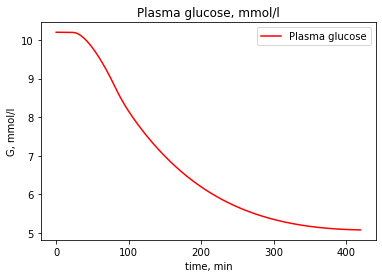

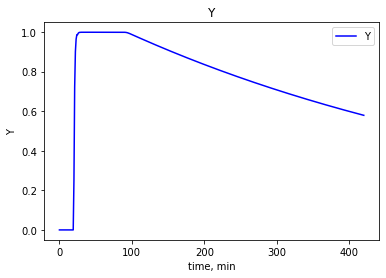

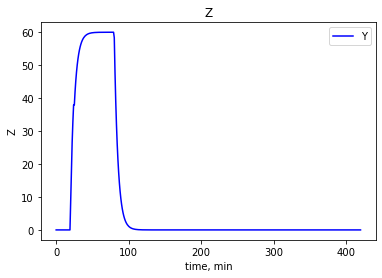

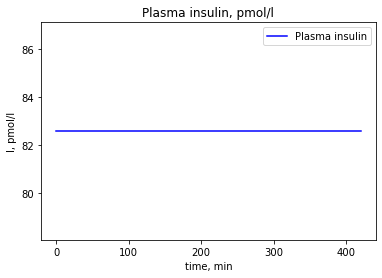

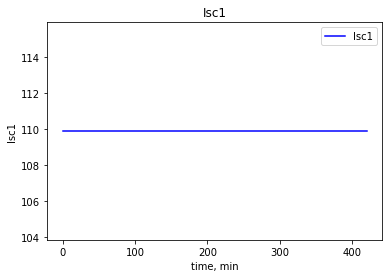

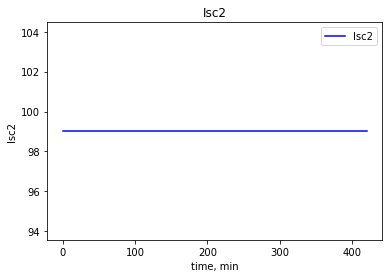

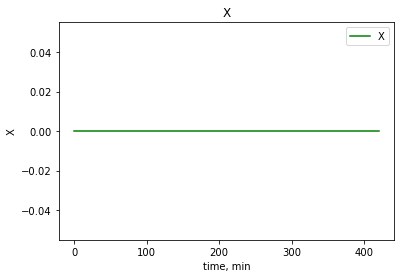

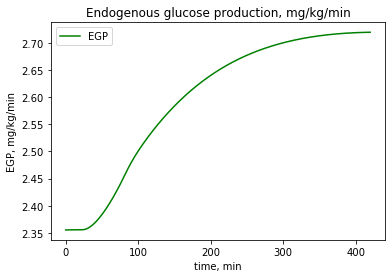

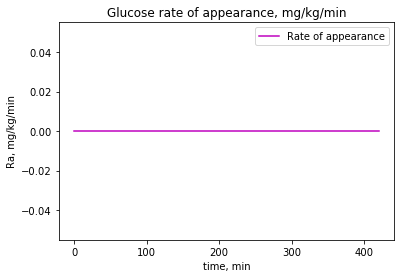

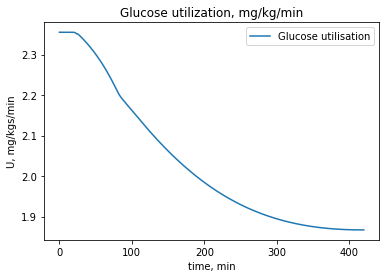

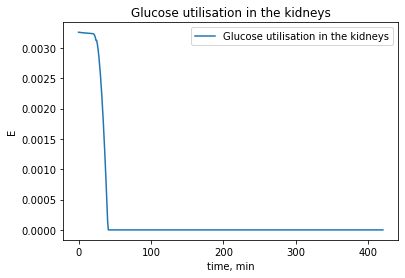

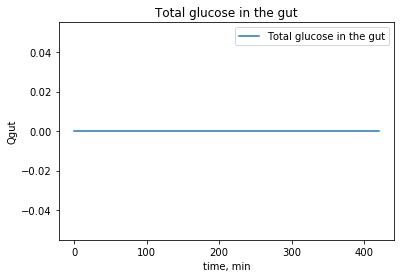

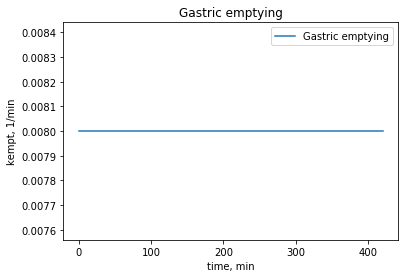

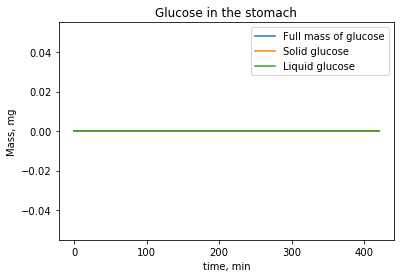

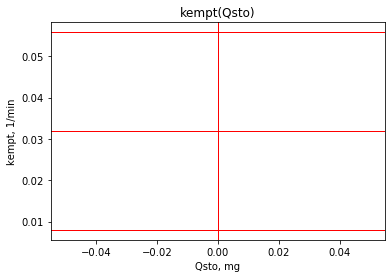

Glucose before, mmol/l: 10.2
Glucose at 40 min, mmol/l: 10.03485102092369
Glucose at 180 min, mmol/l: 6.487067452938074
Glucose at 420 min, mmol/l: 5.082734120111017
Insulin before, pmol/l: 82.57638315441784
Insulin at 40 min, pmol/l: 82.57638315441784
Insulin at 180 min, pmol/l: 82.57638315441784
Insulin at 420 min, pmol/l: 82.57638315441784


In [2]:
### Примеры использования ###

test_Gpb = (4.8 * MG_DL_TO_MMOL_L_CONVENTION_FACTOR) * VG
test_Gp0 = (10.2 * MG_DL_TO_MMOL_L_CONVENTION_FACTOR) * VG
food_and_insulin_time = 25  # Пока что жестко прошито, в планах разделение

final_value = Simulation(
    BW=77, # вес тела, кг
    D=0,  # принятые углеводы, мг
    Gpb=test_Gp0,  # базальная глюкоза, мг/дл
    time=420,  # Время моделирования, мин
    samples=420,  # Количество отсчетов
    Gp0=test_Gp0,  # Начальный уровень сахара в крови
    Djins=0,  # Доза быстрого инсулина
    IIRb=2,  # Базальный инулин
    food_input_time = food_and_insulin_time,  # время приема пищи, мин. от начала моделирования TODO: отделить
    insulin_injection_time = food_and_insulin_time,  # время введения инсулина, мин. от начала моделирования TODO: отделить
    ex_on=True,  # Включение модели упражнений
    ex_start=20,  # время начала упражнений
    ex_finish=80,  # время завершения упражнений
    ex_hr=120,  # пульс при упражнениях
    HRb=60,  # базальный пульс
    output_on=True  # включение вывода графиков
)

print('Glucose before, mmol/l:', final_value[0][0] / MG_DL_TO_MMOL_L_CONVENTION_FACTOR)
print('Glucose at 40 min, mmol/l:', final_value[0][39] / MG_DL_TO_MMOL_L_CONVENTION_FACTOR)
print('Glucose at 180 min, mmol/l:', final_value[0][179] / MG_DL_TO_MMOL_L_CONVENTION_FACTOR)
print('Glucose at 420 min, mmol/l:', final_value[0][419] / MG_DL_TO_MMOL_L_CONVENTION_FACTOR)
print('Insulin before, pmol/l:', final_value[1][0])
print('Insulin at 40 min, pmol/l:', final_value[1][39])
print('Insulin at 180 min, pmol/l:', final_value[1][179])
print('Insulin at 420 min, pmol/l:', final_value[1][419])

